In [1]:
%matplotlib inline

import numpy as np
import os

import tensorflow as tf
import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.contrib.rnn import LSTMCell, GRUCell, LSTMStateTuple
from tensorflow.contrib.layers import safe_embedding_lookup_sparse as embedding_lookup_unique

print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.0.0


# Helper Function

In [2]:
def batch(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
            
    Example:
    batch([[3,7,6],[8,6],[5,7,4,8]])
    array([[3, 8, 5],
           [7, 6, 7],
           [6, 0, 4],
           [0, 0, 8]], dtype=int32)
    """
    
    sequence_length = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_length)
    
    # [batch_size, time_series]
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32)
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element
    
    # switch to time_major as [time_series, batch_size]
    inputs_batch_major = inputs_batch_major.swapaxes(0, 1)
    
    return inputs_batch_major, sequence_length

In [3]:
def random_sequences(length_from, length_to, vocab_lower, vocab_upper, batch_size):
    """ 
    Description:
        Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    Example:
    data = random_sequence(length_from=3, length_to=8, vocab_lower=3, vocab_upper=10, batch_size=10)
    next(data)
    """
    assert length_from <= length_to, "length_from > length_to is error."
    
    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)
    
    while True:
        yield [np.random.randint(low=vocab_lower, high=vocab_upper, size=random_length()).tolist() 
               for _ in range(batch_size)]

In [4]:
class helpers():
    def __init__(self):
        pass

helpers.batch = batch
helpers.random_sequences = random_sequences

# Seq2Seq Model

In designing Seq2Seq graph, the train and inference processes are separated. 
* Therefore we need a property named `_init_decoder_train_connectors` to define the decoder's behavior during training. 
* Besides, in `_init_decoder` property we have to define two types of different `dynamic_rnn_decoder` running for train and inference separatedly.
* In the final, we also need `make_train_inputs` and `make_inference_inputs` to feed the data into the graph.

In [5]:
import math

In [6]:
class Seq2SeqModel():
    
    PAD = 0
    EOS = 1
    
    def __init__(self, encoder_cell, decoder_cell, \
                 vocab_size, embedding_size, \
                 bidirectional=True, attention=False, debug=False):
        
        self.encoder_cell = encoder_cell
        self.decoder_cell = decoder_cell
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.attention = attention
        self.debug = debug
        
        # contruct the rnn definition graph
        self._make_graph()
           
    def _make_graph(self):
        if self.debug:
            self._init_debug_inputs()
        else:
            self._init_placeholders()
            
        self._init_decoder_train_connectors()
        self._init_embeddings()
        
        if self.bidirectional:
            self._init_bidirectional_encoder()
        else:
            self._init_simple_encoder()
        
        self._init_decoder()
        
        self._init_optimizer()
            
    def _init_debug_inputs(self):
        """
        Data is time major. Here we create simple encoder and decoder data. They are the same.
        """
        x = [[5,6,7],
             [7,6,0],
             [0,7,0]]
        xlen = [2,3,1]
        
        self.encoder_inputs = tf.constant(x, dtype=tf.int32, name="encoder_inputs")
        self.encoder_inputs_length = tf.constant(xlen, dtype=tf.int32, name="encoder_inputs_length")
        
        self.decoder_targets = tf.constant(x, dtype=tf.int32, name="deocder_targets")
        self.decoder_targets_length = tf.constant(xlen, dtype=tf.int32, name="decoder_targets_length")
    
    def _init_placeholders(self):
        """Data is time major."""
        self.encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name="encoder_inputs")
        self.encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.int32, name="encoder_inputs_length")
        
        self.decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name="decoder_targets")
        self.decoder_targets_length = tf.placeholder(shape=(None,), dtype=tf.int32, name="decoder_targets_length")
    
    def _init_decoder_train_connectors(self):
        """
        define the decoder's inputs and targets during training
        """
        with tf.variable_scope("DecoderTrainFeeds"):
            sequence_size, batch_size = tf.unstack(tf.shape(self.decoder_targets))
            
            EOS_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * self.EOS
            PAD_SLICE = tf.ones([1, batch_size], dtype=tf.int32) * self.PAD
            
            # add EOS in the front of each decoder targets
            self.decoder_train_inputs = tf.concat([EOS_SLICE, self.decoder_targets], axis=0)
            self.decoder_train_length = self.decoder_targets_length + 1  # +1 stands for adding EOS tag
            
            # add PAD in the end of each decoder targets
            decoder_train_targets = tf.concat([self.decoder_targets, PAD_SLICE], axis=0)
            decoder_train_targets_seq_len, _ = tf.unstack(tf.shape(decoder_train_targets))
            decoder_train_targets_eos_mask = tf.one_hot(self.decoder_train_length - 1, \
                                                        decoder_train_targets_seq_len, \
                                                        on_value=self.EOS, off_value=self.PAD, dtype=tf.int32)
            
            # change to time major
            decoder_train_targets_eos_mask = tf.transpose(decoder_train_targets_eos_mask, [1, 0])
            
            # using one hot to put EOS symbol at the end of target sequence
            decoder_train_targets = tf.add(decoder_train_targets, decoder_train_targets_eos_mask)
            self.decoder_train_targets = decoder_train_targets
            
            self.loss_weights = tf.ones([batch_size, tf.reduce_max(self.decoder_train_length)], \
                                        dtype=tf.float32, name="loss_weights")
    
    def _init_embeddings(self):
        with tf.variable_scope("embedding"):
            sqrt3 = math.sqrt(3)
            initializer = tf.random_uniform_initializer(-sqrt3, sqrt3)
            
            self.embedding_matrix = tf.get_variable("embedding_matrix", \
                                                    shape=[self.vocab_size, self.embedding_size], \
                                                    initializer=initializer, dtype=tf.float32)
            self.encoder_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, \
                                                                  self.encoder_inputs)
            self.decoder_train_inputs_embedded = tf.nn.embedding_lookup(self.embedding_matrix, \
                                                                        self.decoder_train_inputs)
    
    def _init_simple_encoder(self):
        with tf.variable_scope("Encoder"):
            (self.encoder_outputs, self.encoder_state) = tf.nn.dynamic_rnn(cell=self.encoder_cell, \
                                                                          inputs=self.encoder_inputs_embedded, \
                                                                          sequence_length=self.encoder_inputs_length, \
                                                                          time_major=True, dtype=tf.float32)
    
    def _init_bidirectional_encoder(self):
        with tf.variable_scope("BidirectionalEncoder"):
            ((encoder_fw_outputs, encoder_bw_outputs),(encoder_fw_final_state, encoder_bw_final_state)) = \
            tf.nn.bidirectional_dynamic_rnn(cell_fw=self.encoder_cell, cell_bw=self.encoder_cell, \
                                            inputs=self.encoder_inputs_embedded, \
                                            sequence_length=self.encoder_inputs_length, \
                                            dtype=tf.float32, time_major=True)
            
            # concatenate forward and backward outputs
            self.encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)
            
            # concatenate forward and backward final state
            if isinstance(encoder_fw_final_state, LSTMStateTuple):
                encoder_state_c = tf.concat((encoder_fw_final_state.c, encoder_bw_final_state.c), 1, \
                                            name="bidirectional_concat_c")
                encoder_state_h = tf.concat((encoder_fw_final_state.h, encoder_bw_final_state.h), 1, \
                                            name="bidirectional_concat_h")
                self.encoder_state = LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)
                
            elif isinstance(encoder_fw_final_state, tf.Tensor):
                self.encoder_state = tf.concat((encoder_fw_final_state, encoder_bw_final_state), 1, \
                                               name="bidirectional_concat")
                
    
    def _init_decoder(self):
        with tf.variable_scope("Decoder") as scope:
            def output_fn(outputs):
                return tf.contrib.layers.linear(outputs, self.vocab_size, scope=scope)
            
            # define both decoder_fn_train and decoder_fn_inference
            if not self.attention:
                decoder_fn_train = seq2seq.simple_decoder_fn_train(encoder_state=self.encoder_state)
                decoder_fn_inference = seq2seq.simple_decoder_fn_inference(output_fn=output_fn, \
                                                                           encoder_state=self.encoder_state, \
                                                                           embeddings=self.embedding_matrix, \
                                                                           start_of_sequence_id=self.EOS, \
                                                                           end_of_sequence_id=self.EOS, \
                                                                           maximum_length=tf.reduce_max(\
                                                                                self.encoder_inputs_length) + 3, \
                                                                           num_decoder_symbols=self.vocab_size)
            else:
                # attention_states: [batch_size, max_time, num_units]
                attention_states = tf.transpose(self.encoder_outputs, [1,0,2])
                
                (attention_keys, attention_values, attention_score_fn, attention_contruct_fn) = \
                seq2seq.prepare_attention(attention_states=attention_states, \
                                          attention_option="bahdanau", \
                                          num_units=self.decoder_cell.output_size)
                
                decoder_fn_train = seq2seq.attention_decoder_fn_train(encoder_state=self.encoder_state, \
                                                                      attention_keys=attention_keys, \
                                                                      attention_values=attention_values, \
                                                                      attention_score_fn=attention_score_fn, \
                                                                      attention_construct_fn=attention_contruct_fn)
                
                decoder_fn_inference = seq2seq.attention_decoder_fn_inference(output_fn=output_fn, \
                                                                              encoder_state=self.encoder_state, \
                                                                              attention_keys=attention_keys, \
                                                                              attention_values=attention_values, \
                                                                              attention_score_fn=attention_score_fn, \
                                                                              attention_construct_fn=attention_contruct_fn, \
                                                                              embeddings=self.embedding_matrix, \
                                                                              start_of_sequence_id=self.EOS, \
                                                                              end_of_sequence_id=self.EOS, \
                                                                              maximum_length=tf.reduce_max(self.encoder_inputs_length) + 3, \
                                                                              num_decoder_symbols=self.vocab_size)
            
            # dynamic rnn decoder for train
            # logits and prediction for train
            (self.decoder_output_train, self.decoder_state_train, self.decoder_context_state_train) = \
            seq2seq.dynamic_rnn_decoder(cell=self.decoder_cell, decoder_fn=decoder_fn_train, \
                                        inputs=self.decoder_train_inputs_embedded, \
                                        sequence_length=self.decoder_train_length, \
                                        time_major=True, scope=scope)
            
            self.decoder_logits_train = output_fn(self.decoder_output_train)
            self.decoder_prediction_train = tf.argmax(self.decoder_logits_train, axis=-1, name="decoder_prediction_train")
            
            scope.reuse_variables()
            
            # dynamic rn decoder for inference
            # prediction for inference
            (self.decoder_logits_inference, self.decoder_state_inference, self.decoder_context_state_inference) = \
            seq2seq.dynamic_rnn_decoder(cell=self.decoder_cell, decoder_fn=decoder_fn_inference, \
                                        time_major=True, scope=scope)
            
            self.decoder_prediction_inference = tf.argmax(self.decoder_logits_inference, axis=-1, name='decoder_prediction_inference')
    
    def _init_optimizer(self):
        logits = tf.transpose(self.decoder_logits_train, [1, 0, 2])
        targets = tf.transpose(self.decoder_train_targets, [1, 0])
        
        self.loss = seq2seq.sequence_loss(logits=logits, targets=targets, weights=self.loss_weights)
        self.train_op = tf.train.AdamOptimizer().minimize(self.loss)
        
    def make_train_inputs(self, input_seq, target_seq):
        inputs_, inputs_length_ = helpers.batch(input_seq)
        targets_, targets_length_ = helpers.batch(target_seq)
        
        return {self.encoder_inputs: inputs_, self.encoder_inputs_length: inputs_length_, \
                self.decoder_targets: targets_, self.decoder_targets_length: targets_length_}
    
    def make_inference_inputs(self, input_seq):
        inputs_, inputs_length_ = helpers.batch(input_seq)
        
        return {self.encoder_inputs: inputs_, self.encoder_inputs_length: inputs_length_}

## Simple API

In [7]:
def make_seq2seq_model(**kwargs):
    args = dict(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(20), vocab_size=10, embedding_size=10, \
                attention=True, bidirectional=True, debug=False)
    args.update(kwargs)
    return Seq2SeqModel(**args)

In [8]:
def train_on_copy_task(sess, model, 
                       length_from=3, length_to=8, 
                       vocab_lower=2, vocab_upper=10, 
                       batch_size = 100, max_batches=5000, 
                       batches_in_epoch=1000, verbose=True):
    
    batches = helpers.random_sequences(length_from=length_from, length_to=length_to, 
                                       vocab_lower=vocab_lower, vocab_upper=vocab_upper, 
                                       batch_size=batch_size)
    
    loss_history = []
    
    try:
        for batch in range(max_batches + 1):
            batch_data = next(batches)
            
            # training for copying task
            # both the input and target sequence are the same
            fd = model.make_train_inputs(batch_data, batch_data)
            _, loss = sess.run([model.train_op, model.loss], fd)
            loss_history.append(loss)
            
            if verbose:
                if batch == 0 or batch % batches_in_epoch == 0:
                    print('batch: {}'.format(batch))
                    print('minibatch loss: {}'.format(sess.run(model.loss, fd)))
                    for i, (enc_input, dec_pred) in \
                        enumerate(zip(fd[model.encoder_inputs].T, sess.run(model.decoder_prediction_train, fd).T)):
                        print('Sample: {}'.format(i + 1))
                        print('encoder input: {}'.format(enc_input))
                        print('decoder train predicted: {}'.format(dec_pred))
                        # it is necessary to output the first data as the example
                        if i >= 2:
                            break
                    print()
            
    except KeyboardInterrupt:
        print("Training interrupted.")
        
    return loss_history
    

## Simple example

In [9]:
import matplotlib.pyplot as plt

In [ ]:
types = "train"

if types == "fw-debug":
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        model = make_seq2seq_model(debug=True)
        sess.run(tf.global_variables_initializer())
        print("Debug Input:")
        print(sess.run(model.encoder_inputs))
        print("Debug Pred:")
        print(sess.run(model.decoder_prediction_train))
    
elif types == "fw-inf":
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        model = make_seq2seq_model()
        sess.run(tf.global_variables_initializer())
        fd = model.make_inference_inputs([[3, 7, 6, 8], [7,7]])
        inference = sess.run(model.decoder_prediction_inference, fd)
        print(inference)
    
elif types == "train":
    tracks = {}
    
    # train with attention 
    tf.reset_default_graph()
    with tf.Session() as sess:
        model = make_seq2seq_model(attention=True)
        sess.run(tf.global_variables_initializer())
        loss_track_attention = train_on_copy_task(sess, model)
    plt.plot(loss_track_attention, label='attention')
    print('loss {:.4f}'.format(loss_track_attention[-1]))
    
    # train without attention
    tf.reset_default_graph()
    with tf.Session() as sess:
        model = make_seq2seq_model(attention=False)
        sess.run(tf.global_variables_initializer())
        loss_track_no_attention = train_on_copy_task(sess, model)
    plt.plot(loss_track_no_attention, label='no attention')
    print('loss {:.4f}'.format(loss_track_no_attention[-1]))
    
    plt.legend()
    
else:
    
    tf.reset_default_graph()
    sess = tf.InteractiveSession()
    model = make_seq2seq_model(debug=False)
    sess.run(tf.global_variables_initializer())
    
    fd = model.make_inference_inputs([[3, 7, 6, 8],[7,3]])
    inference, = sess.run([model.decoder_prediction_inference], fd)
    print(inference)

# Seq2Seq Compare

## LSTMCell Consisting Bidirectional Dynamic RNN with Attention Mechanism

batch: 0
minibatch loss: 2.3217923641204834
Sample: 1
encoder input: [5 2 7 8 6 0 0 0]
decoder train predicted: [6 6 0 5 5 0 0 0 0]
Sample: 2
encoder input: [9 5 6 3 2 2 4 0]
decoder train predicted: [6 6 6 6 6 6 6 6 0]
Sample: 3
encoder input: [9 4 5 2 6 6 8 0]
decoder train predicted: [6 6 6 6 6 6 6 6 0]

batch: 1000
minibatch loss: 0.24910122156143188
Sample: 1
encoder input: [7 8 6 6 7 0 0 0]
decoder train predicted: [7 8 6 6 7 1 0 0 0]
Sample: 2
encoder input: [3 2 6 0 0 0 0 0]
decoder train predicted: [3 2 6 1 0 0 0 0 0]
Sample: 3
encoder input: [2 7 8 4 2 6 5 0]
decoder train predicted: [2 7 8 4 2 6 5 1 0]

batch: 2000
minibatch loss: 0.09602542221546173
Sample: 1
encoder input: [3 7 7 0 0 0 0 0]
decoder train predicted: [3 7 7 1 0 0 0 0 0]
Sample: 2
encoder input: [8 8 8 3 4 3 4 0]
decoder train predicted: [8 8 8 3 4 3 4 1 0]
Sample: 3
encoder input: [5 5 9 0 0 0 0 0]
decoder train predicted: [5 5 9 1 0 0 0 0 0]

batch: 3000
minibatch loss: 0.04288767650723457
Sample: 1
encoder

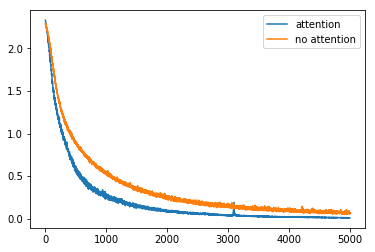

In [10]:
tf.set_random_seed(3)

# train with attention 
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(20), 
                               vocab_size=10, embedding_size=10, attention=True, bidirectional=True, debug=False)
    sess.run(tf.global_variables_initializer())
    loss_track_attention = train_on_copy_task(sess, model)
plt.plot(loss_track_attention, label='attention')
print('loss {:.4f}'.format(loss_track_attention[-1]))

# train without attention
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(20), 
                               vocab_size=10, embedding_size=10, attention=False, bidirectional=True, debug=False)
    sess.run(tf.global_variables_initializer())
    loss_track_no_attention = train_on_copy_task(sess, model)
plt.plot(loss_track_no_attention, label='no attention')
print('loss {:.4f}'.format(loss_track_no_attention[-1]))

plt.legend()

## Forward / Bidirectional Encoder Combining No Attention / Attention 

loss 0.1940
loss 0.0139
loss 0.0604
loss 0.0122


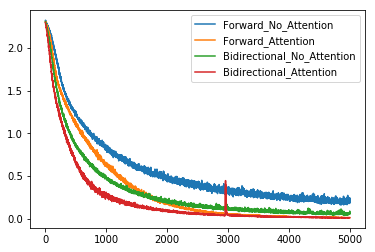

In [9]:
tf.set_random_seed(3)

# Forward + No Attention
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(10), 
                               vocab_size=10, embedding_size=10, attention=False, bidirectional=False, debug=False)
    sess.run(tf.global_variables_initializer())
    Forward_No_Attention = train_on_copy_task(sess, model, verbose=False)
plt.plot(Forward_No_Attention, label='Forward_No_Attention')
print('loss {:.4f}'.format(Forward_No_Attention[-1]))

# Forward + Attention
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(10), 
                               vocab_size=10, embedding_size=10, attention=True, bidirectional=False, debug=False)
    sess.run(tf.global_variables_initializer())
    Forward_Attention = train_on_copy_task(sess, model, verbose=False)
plt.plot(Forward_Attention, label='Forward_Attention')
print('loss {:.4f}'.format(Forward_Attention[-1]))

# Bidirectional + No Attention
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(20), 
                               vocab_size=10, embedding_size=10, attention=False, bidirectional=True, debug=False)
    sess.run(tf.global_variables_initializer())
    Bidirectional_No_Attention = train_on_copy_task(sess, model, verbose=False)
plt.plot(Bidirectional_No_Attention, label='Bidirectional_No_Attention')
print('loss {:.4f}'.format(Bidirectional_No_Attention[-1]))

# Bidirectional + Attention
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(20), 
                               vocab_size=10, embedding_size=10, attention=True, bidirectional=True, debug=False)
    sess.run(tf.global_variables_initializer())
    Bidirectional_Attention = train_on_copy_task(sess, model, verbose=False)
plt.plot(Bidirectional_Attention, label='Bidirectional_Attention')
print('loss {:.4f}'.format(Bidirectional_Attention[-1]))

plt.legend()

From the above result, the DNN with both the bidirectional and the attention is the best practice.

## LSTMCell / GRUCell in Bidirectional Dynamic RNN with Attention Mechanism

In [12]:
import time
import pandas as pd

In [13]:
tf.set_random_seed(3)

# LSTM Cell
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=LSTMCell(10), decoder_cell=LSTMCell(20), 
                               vocab_size=10, embedding_size=10, attention=True, bidirectional=True, debug=False)
    sess.run(tf.global_variables_initializer())
    start = time.time()
    LSTM_Loss = train_on_copy_task(sess, model, verbose=False) 
    lstm_train_peroid = time.time() - start
    
# GRU Cell
tf.reset_default_graph()
with tf.Session() as sess:
    model = make_seq2seq_model(encoder_cell=GRUCell(10), decoder_cell=GRUCell(20), 
                               vocab_size=10, embedding_size=10, attention=True, bidirectional=True, debug=False)
    sess.run(tf.global_variables_initializer())
    start = time.time()
    GRU_Loss = train_on_copy_task(sess, model, verbose=False) 
    gru_train_peroid = time.time() - start

In [17]:
lstm = pd.Series(LSTM_Loss, name='lstm')
gru = pd.Series(GRU_Loss, name='gru')
loss_batch = pd.DataFrame(dict(lstm=lstm, gru=gru))
loss_batch.index.name = 'batch'

lstm.index = lstm.index / lstm_train_peroid
gru.index = gru.index / gru_train_peroid
tracks_time = pd.DataFrame(dict(lstm=lstm, gru=gru)).ffill()

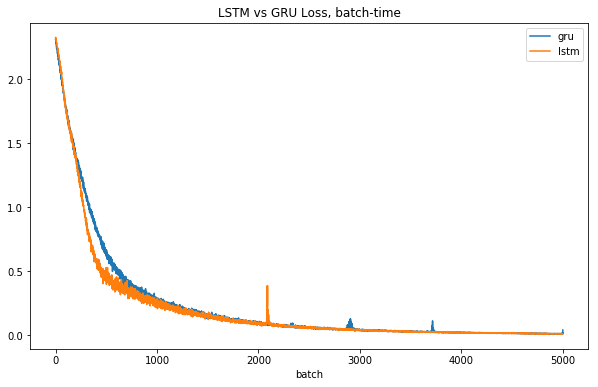

In [18]:
loss_batch.plot(figsize=(10,6), title="LSTM vs GRU Loss, batch-time")

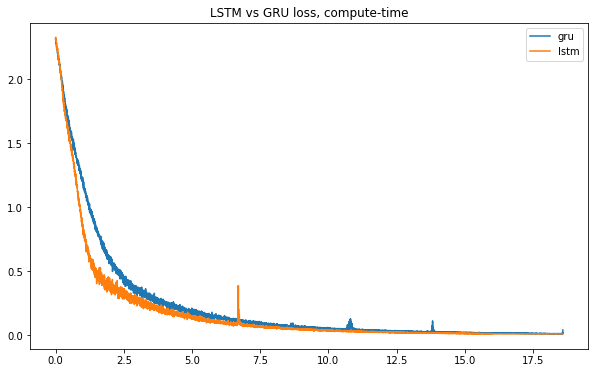

In [19]:
tracks_time.plot(figsize=(10, 6), title="LSTM vs GRU loss, compute-time")

In the above experiment, it's showed that GRU provides better training performance in compute-time.